# _Dataviz Code Session_: Dados Multidimensionais

## Objetivos da DCS

- Aplicar técnicas de dataviz para plotagem e manipulação de representações visuais de dados multidimensionais.
- Elaborar RV para dados do comércio exterior, enfatizando a influência do Brasil sobre uma amostra de países do continente americano.

## Ferramentas utilizadas

- Módulos Python
    - `pandas`
    - `matplotlib`
    - `seaborn`
    - `plotly`
    - `os`
    - `sys`

## Aplicação do modelo referencial

- Vide {numref}`Capítulo %s <cap:estetica>`.

In [1]:
import plotly.express as px
from plotly.offline import plot
from IPython.display import display, HTML

import pandas as pd, matplotlib.pyplot as plt, seaborn as sb
import os
import sys; sys.path.insert(1,'../dcs')
import dcs24

plt.style.use('../etc/gcpeixoto-datavis.mplstyle') # style sheet

### Dados de entrada pré-processados

- Carregamento de dados

In [2]:
# carrega valores para ano y
y = 2020

# planilhas
# imp: importação; exp: exportação; cc: códigos de países/blocos; tgt_dir: diretório-fonte dos dados
imp, exp, cc, _, tgt_dir = dcs24.get_comex(y)

# remove entradas duplicadas de países
cc = cc.drop_duplicates()

# dados do PIB anualizado de países de interesse (Banco Mundial)
GDP = pd.read_csv('../data/gdp-world-2021.csv')

COMEX files successfuly loaded from: ../data/comex-2020


#### Processamento adicional

- Agrupamento por valor FOB

**Nota:** FOB (_Free On Board_) é o valor monetário em USD da mercadoria comercializada desconsiderando frete e seguro.

In [3]:
FOB_imp = imp.groupby('País de origem')['Valor Free On Board'].sum()
FOB_exp = exp.groupby('País de destino')['Valor Free On Board'].sum()

- Filtragem por comércio bilateral com países das Américas

In [4]:
americas = cc[cc['Nome do bloco'].str.find('América') == 0]

fimp, fexp = {}, {}

for i in americas['Código do país'].values:    
    
    try:
        country = americas[americas['Código do país'] == i]['Nome do país'].values[0]               
        block = americas[americas['Código do país'] == i]['Nome do bloco'].values[0]               
        
        fimp[country] = (FOB_imp[i],block)
        fexp[country] = (FOB_exp[i],block)
    finally:
        continue


fob = []
block = []
for v in fimp.values():
    fobi, blocki = v
    fob.append(fobi)
    block.append(blocki)

fobe = []
for v in fexp.values():
    fobi,_ = v
    fobe.append(fobi)

FOB = pd.DataFrame({'País':fimp.keys(),'Bloco':block,'FOB importado (USD)':fob,'FOB exportado (USD)':fobe})

- Mesclagem de FOB com dados do PIB

In [5]:
FOB_GDP = FOB.merge(GDP,how='inner',on='País') # países com mesma pronúncia em PT e EN
FOB_GDP_2020 = FOB_GDP[FOB_GDP.columns[[0,1,2,3,6]]]

- Criação de séries auxiliares

In [6]:
# PIB brasileiro
FOB_GDP_2020['GDP 2020 Brazil'] = GDP[GDP['País'] == 'Brazil']['GDP 2020'].values[0]

# parâmetros
FOB_GDP_2020['FOB_exp/GDP'] = FOB_GDP_2020['FOB exportado (USD)']/FOB_GDP_2020['GDP 2020']*100 # lambda 1
FOB_GDP_2020['FOB_imp/GDP_bra'] = FOB_GDP_2020['FOB exportado (USD)']/FOB_GDP_2020['GDP 2020 Brazil']*100 # lambda 2

# valores em escala
scale = 1e9 # billion dollars
FOB_GDP_2020['FOB importado (USD) scaled'] = FOB_GDP_2020['FOB importado (USD)']/scale
FOB_GDP_2020['FOB exportado (USD) scaled'] = FOB_GDP_2020['FOB exportado (USD)']/scale
FOB_GDP_2020['GDP 2020 Brazil scaled'] = FOB_GDP_2020['GDP 2020 Brazil']/scale
FOB_GDP_2020['GDP 2020 scaled'] = FOB_GDP_2020['GDP 2020']/scale

FOB_GDP_2020

País                     Bloco  FOB importado (USD)  \
0     Argentina            América do Sul           7897095769   
1         Aruba  América Central e Caribe                   78   
2      Barbados  América Central e Caribe               846002   
3        Belize  América Central e Caribe               258802   
4         Chile            América do Sul           2895554015   
5    Costa Rica  América Central e Caribe             42248151   
6          Cuba  América Central e Caribe              3052129   
7      Dominica  América Central e Caribe                14826   
8     Guatemala  América Central e Caribe             48547341   
9         Haiti  América Central e Caribe              1109619   
10     Honduras  América Central e Caribe             10774506   
11      Jamaica  América Central e Caribe               891715   
12         Peru            América do Sul            730269814   
13  El Salvador  América Central e Caribe              5297154   
14     Suriname  América Central e Caribe              2608842   

    FOB exportado (USD)      GDP 2020  GDP 2020 Brazil  FOB_exp/GDP  \
0            8488738068  3.855402e+11     1.448560e+12     2.201778   
1              28908881  2.610039e+09     1.448560e+12     1.107603   
2              11622811  4.671800e+09     1.448560e+12     0.248787   
3               6501915  2.080000e+09     1.448560e+12     0.312592   
4            3849842523  2.527272e+11     1.448560e+12     1.523319   
5             244195942  6.215800e+10     1.448560e+12     0.392863   
6             209301226  1.073520e+11     1.448560e+12     0.194967   
7               2742069  5.042148e+08     1.448560e+12     0.543830   
8             256070608  7.762549e+10     1.448560e+12     0.329880   
9              57319552  1.450822e+10     1.448560e+12     0.395083   
10            103274579  2.382784e+10     1.448560e+12     0.433420   
11            206461408  1.381243e+10     1.448560e+12     1.494751   
12           1659787430  2.017051e+11     1.448560e+12     0.822878   
13             85167449  2.456302e+10     1.448560e+12     0.346730   
14             31376040  2.911807e+09     1.448560e+12     1.077545   

    FOB_imp/GDP_bra  FOB importado (USD) scaled  FOB exportado (USD) scaled  \
0          0.586012                7.897096e+00                    8.488738   
1          0.001996                7.800000e-08                    0.028909   
2          0.000802                8.460020e-04                    0.011623   
3          0.000449                2.588020e-04                    0.006502   
4          0.265770                2.895554e+00                    3.849843   
5          0.016858                4.224815e-02                    0.244196   
6          0.014449                3.052129e-03                    0.209301   
7          0.000189                1.482600e-05                    0.002742   
8          0.017678                4.854734e-02                    0.256071   
9          0.003957                1.109619e-03                    0.057320   
10         0.007129                1.077451e-02                    0.103275   
11         0.014253                8.917150e-04                    0.206461   
12         0.114582                7.302698e-01                    1.659787   
13         0.005879                5.297154e-03                    0.085167   
14         0.002166                2.608842e-03                    0.031376   

    GDP 2020 Brazil scaled  GDP 2020 scaled  
0              1448.559976       385.540225  
1              1448.559976         2.610039  
2              1448.559976         4.671800  
3              1448.559976         2.080000  
4              1448.559976       252.727194  
5              1448.559976        62.158002  
6              1448.559976       107.352000  
7              1448.559976         0.504215  
8              1448.559976        77.625487  
9              1448.559976        14.508218  
10             1448.559976        23.827841  


## Mapeamento

- Criação de _scatterplot_ primário para visualizar relação de importação/exportação;
- Uso de plot 3D para relacionar dados com GDP ou continente;
    - _Bubbleplots_ como forma reduzida;

## Visualização

### Iterando em RVs primárias

- Vamos plotar o gráfico de dispersão $\lambda_i(y)$ vs. $\lambda_e(y)$ para o ano $y$, em que:
    - $p$: país parceiro do Brasil com balança comercial ativa;
    - $\lambda_i$: razão entre FOB importado do país $p$ pelo Brasil e o PIB brasileiro;
    - $\lambda_e$: razão entre FOB exportado para o país $p$ pelo Brasil e o PIB do país $p$;

**Interpretação:** $\lambda_i$ mostra o nível de dependência comercial do Brasil do país $p$ em relação à riqueza doméstica, ao passo que $\lambda_e$ mostra o nível de influência comercial do Brasil sobre o país $p$ em relação à riqueza estrangeira (Nota: parâmetros não oficiais.). 

- Gráfico de dispersão de parâmetros
    - Exploração básica dos parâmetros
    - Plotagem simples
    - Linha de referência (importação)
    - Considerações preliminares

In [7]:
import plotly.express as px
from plotly.offline import plot
import numpy as np
import pandas as pd
from IPython.display import display, HTML

fig = px.scatter_3d(FOB_GDP_2020, 
                    x='FOB_imp/GDP_bra', 
                    y='FOB_exp/GDP', 
                    z='GDP 2020 scaled', 
                    size='GDP 2020 scaled', 
                    color='Bloco',
                    hover_data=['País','FOB importado (USD) scaled','FOB exportado (USD) scaled'])
fig.update_layout(margin=dict(l=50, r=50, t=50, b=50),
                  font=dict(size=10))
plot(fig, show_link=False,filename=os.path.join(tgt_dir,'comex-example.html'))
display(HTML(os.path.join(tgt_dir,'comex-example.html')))

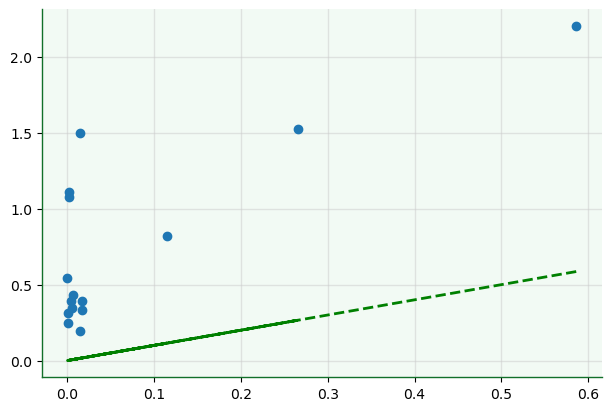

In [8]:
fig, ax = plt.subplots(figsize=(6,4),constrained_layout=True)
ax.plot(FOB_GDP_2020['FOB_imp/GDP_bra'],FOB_GDP_2020['FOB_exp/GDP'],'o');
ax.plot(FOB_GDP_2020['FOB_imp/GDP_bra'],FOB_GDP_2020['FOB_imp/GDP_bra'],'--g');

- Visualização 3D: parâmetros x PIB
    - Problemas com plotagem 3D
        - Oclusão: elementos gráficos escondidos por overlap
        - Identificação: posição do elemento gráfico em relação ao eixo
    - Exploração de propriedades do `plotly`

In [9]:
fig = px.scatter_3d(FOB_GDP_2020, 
                    x='FOB_imp/GDP_bra', 
                    y='FOB_exp/GDP', 
                    z='GDP 2020 scaled', 
                    size='GDP 2020 scaled', 
                    color='Bloco',
                    hover_data=['País','FOB importado (USD) scaled','FOB exportado (USD) scaled'])
fig.update_layout(margin=dict(l=50, r=50, t=50, b=50),
                  font=dict(size=10))
plot(fig, show_link=False,filename=os.path.join(tgt_dir,'comex-example.html'))
display(HTML(os.path.join(tgt_dir,'comex-example.html')))

- Scatterplot + país (cor)
    - Adicionando cor para identificar país
    - Paleta de cor adequada?

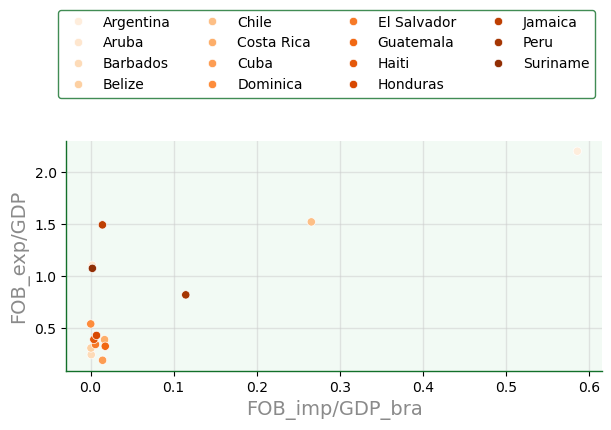

In [10]:
fig, ax = plt.subplots(figsize=(6,4),constrained_layout=True)
f = sb.scatterplot(data=FOB_GDP_2020.sort_values('País'),x='FOB_imp/GDP_bra', y='FOB_exp/GDP', 
                   hue='País', palette='Oranges',
                   legend='brief', ax=ax)
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.6),ncol=4)
ax.set_axisbelow(True) # below grid lines

- Scatterplot + PIB (tamanho)
    - Redução de dimensionalidade associando PIB com tamanho
    - Formação do _bubbleplot_
    - Estudo: 
        - `size`, `sizes`
        - `bbox_to_anchor`
        - `set_axis_below`
    - Problemas?

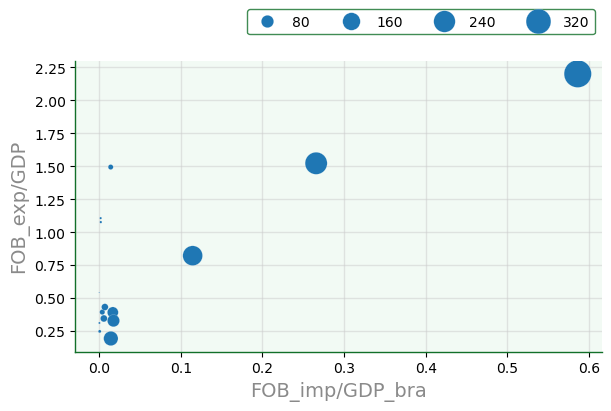

In [11]:
min_gdp = min(FOB_GDP_2020['GDP 2020 scaled'])
max_gdp = max(FOB_GDP_2020['GDP 2020 scaled'])

fig, ax = plt.subplots(figsize=(6,4),constrained_layout=True)
f = sb.scatterplot(data=FOB_GDP_2020.sort_values('País'),x='FOB_imp/GDP_bra', y='FOB_exp/GDP', 
                   size='GDP 2020 scaled', palette='Oranges', sizes = (min_gdp,max_gdp),
                   legend='brief', ax=ax)
ax.set_axisbelow(True) # below grid lines

plt.legend(loc='upper right', bbox_to_anchor=(1, 1.2),ncol=4);

## RV finalística

- Bubbleplot
    - Associação de cor a país, tamanho a PIB
    - Melhoria da estétitca

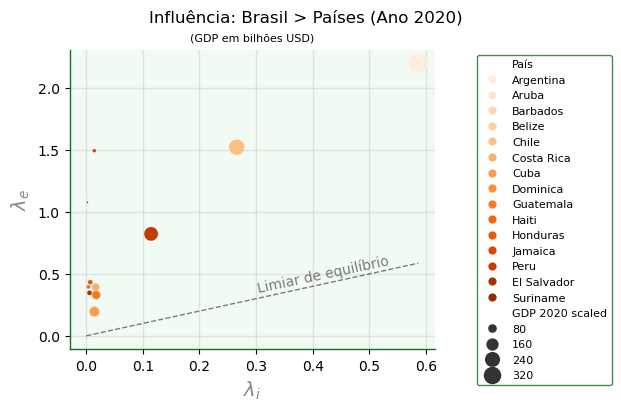

In [12]:

fig, ax = plt.subplots(figsize=(6,4),constrained_layout=True)

# bubble plot
f1 = sb.scatterplot(data=FOB_GDP_2020,x='FOB_imp/GDP_bra', y='FOB_exp/GDP', 
                   hue='País', alpha=1.0, 
                   size='GDP 2020 scaled', sizes = (min_gdp/2,max_gdp/2),
                   palette='Oranges',
                   legend='brief', 
                   ax=ax)

# line plot
f2 = sb.lineplot(data=FOB_GDP_2020,x='FOB_imp/GDP_bra', y='FOB_imp/GDP_bra', 
                color='black',linestyle='--',alpha=0.5, linewidth=1.0, 
                ax=ax)

# decoração
ax.set_axisbelow(True) # below grid lines
ax.axis('tight')

ax.annotate('Limiar de equilíbrio',xy=(0.3,0.35),color='black',alpha=0.5, rotation=12)
ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),ncol=1, fontsize=8)

ax.set_xlabel('$\lambda_i$')
ax.set_ylabel('$\lambda_e$')

fig.suptitle('Influência: Brasil > Países (Ano 2020)')
ax.set_title('(GDP em bilhões USD)',fontsize=8);